In [2]:
import numpy as np
import panadas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [3]:
#use GPU for computing if not the CPu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:
# use ticker symbola e.g(AAPL) to identify sotcks
ticker = 'AAPL'
# accessing data relating to stock as initalized above
df = yf.download(ticker, '2020-01-01')

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

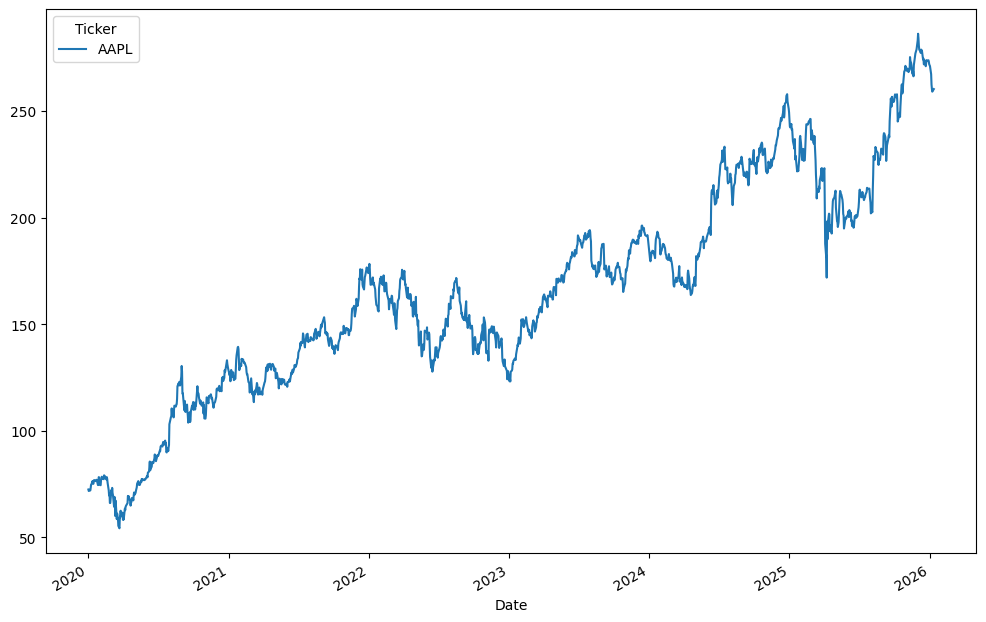

In [5]:
# prints chart
df.Close.plot(figsize=(12, 8))

In [10]:
#set the data scaling type
scaler = StandardScaler()
# scale all data
df['Close'] = scaler.fit_transform(df['Close'])

In [11]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.857389
2020-01-03,-1.871472
2020-01-06,-1.860042
2020-01-07,-1.866842
2020-01-08,-1.843693
...,...
2026-01-06,1.938154
2026-01-07,1.897578
2026-01-08,1.871794


In [15]:
# set the amount of data to look at
seq_length = 60
data = []
# iterate previouse stock data into array based on seq_length
for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])
#add array to numpuy
data = np.array(data)
#training data set size (80% train 20% predict)
train_size = int(0.8 * len(data))
#train the NN on data except for the last piece which we will predict
X_train = torch.from_numpy(data[:train_size, :-1, :])
#only trains the last element 
y_train = torch.from_numpy(data[:train_size, -1, :])
# test the sequence set for correct predictions
X_test = torch.from_numpy(data[train_size:, :-1, :])
#test last data point prediction
y_test = torch.from_numpy(data[train_size, -1, :])
#this creates a tensors with the sequence data

In [27]:
# create an object to predict inheriting from pytorch NN
class PredictionModel(nn.Module):

    def __init__ (self, input_dim, hidden_dim, num_layers, output_dim):
        #initalizes the prediction modle
        super(PredictionModel, self).__init__()
        # this is the number of layers of neurons in our nerual netowrk
        self.num_layers = num_layers
        # the hidden dimesnsion count
        self.hidden_dim = hidden_dim
        #set the number of neruons per layer and number of layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        #P.S reaserch LSTM's 
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        #lost the plot
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:,-1,:])

        return out
        

In [30]:
# creates an instance of the class setting the parameters and sending it to device
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [31]:
criterion = nn.MSELoss()
#optimizes model during the training
optimizer = optim.Adam(model.parameters(), lr=0.01)